In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.8 MB/s eta 0:00:00


In [ ]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
!pip install efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from efficientnet.tfkeras import EfficientNetBv2

# Define custom F1 score function
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='true_positives', initializer='zeros')
        self.fp = self.add_weight(name='false_positives', initializer='zeros')
        self.fn = self.add_weight(name='false_negatives', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=1)
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
        false_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 1)), tf.float32))
        false_negatives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 0)), tf.float32))

        self.tp.assign_add(true_positives)
        self.fp.assign_add(false_positives)
        self.fn.assign_add(false_negatives)

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        f1_score = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        return f1_score

# Set your data paths
train_data_dir = "/content/drive/MyDrive/processed_images/train"
val_data_dir = "/content/drive/MyDrive/processed_images/validation"

# Define the new input shape based on your image size
input_shape = (512, 512, 3)

# Create EfficientNetv2 model
base_model = EfficientNetv2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Create data generators for training and validation
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

# Define number of epochs
epochs = 10

# Create early stopping callback
early_stopping = EarlyStopping(
      monitor = "val_loss",
      patience = 10
)

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping],
    verbose=1
)


Found 4568 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.
Epoch 1/10
143/143 [==============================] - 101s 580ms/step - loss: 0.6461 - accuracy: 0.7469 - f1_score: 0.7377 - precision_13: 0.8397 - recall_13: 0.6377 - val_loss: 0.4170 - val_accuracy: 0.8470 - val_f1_score: 0.7744 - val_precision_13: 0.8721 - val_recall_13: 0.8164
Epoch 2/10
143/143 [==============================] - 82s 572ms/step - loss: 0.4004 - accuracy: 0.8496 - f1_score: 0.8208 - precision_13: 0.8732 - recall_13: 0.8187 - val_loss: 0.3015 - val_accuracy: 0.8820 - val_f1_score: 0.8728 - val_precision_13: 0.9003 - val_recall_13: 0.8680
Epoch 3/10
143/143 [==============================] - 80s 560ms/step - loss: 0.3484 - accuracy: 0.8684 - f1_score: 0.8420 - precision_13: 0.8865 - recall_13: 0.8483 - val_loss: 0.2869 - val_accuracy: 0.8951 - val_f1_score: 0.8926 - val_precision_13: 0.8998 - val_recall_13: 0.8872
Epoch 4/10
143/143 [==============================] - 81s 566ms/step - l

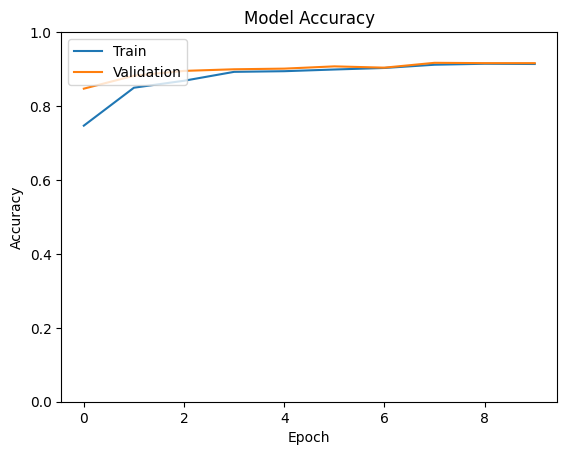

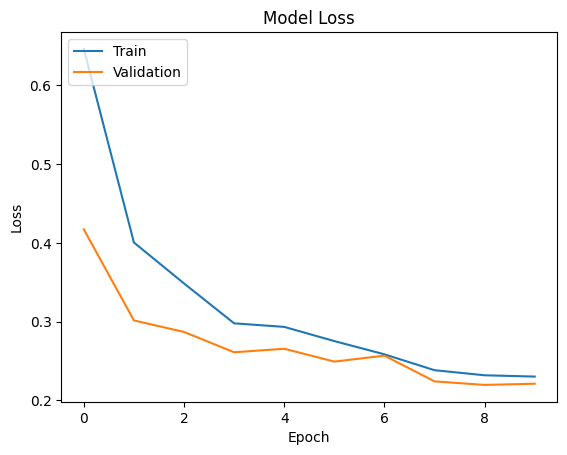

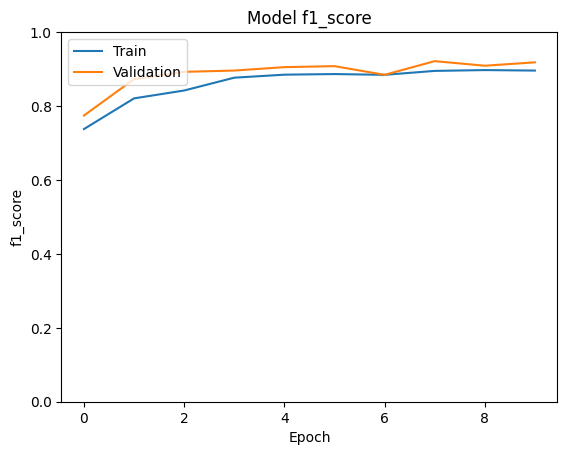

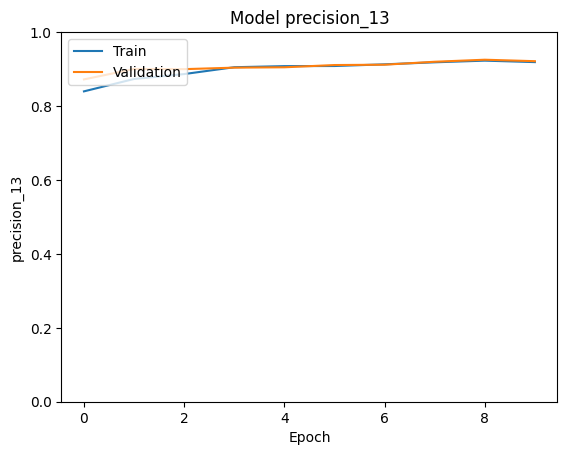

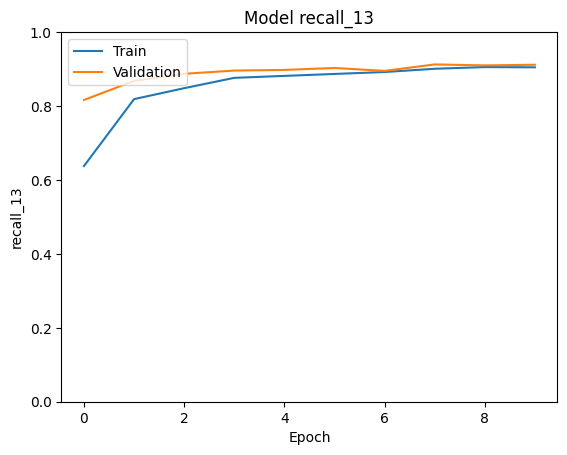

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the 'history' object from model training
# history = model.fit(...)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0,1)
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation f1_score values
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model f1_score')
plt.xlabel('Epoch')
plt.ylabel('f1_score')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0,1)
plt.show()

# Plot training & validation precision_13 values
plt.plot(history.history['precision_13'])
plt.plot(history.history['val_precision_13'])
plt.title('Model precision_13')
plt.xlabel('Epoch')
plt.ylabel('precision_13')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0,1)
plt.show()

# Plot training & validation recall_13 values
plt.plot(history.history['recall_13'])
plt.plot(history.history['val_recall_13'])
plt.title('Model recall_13')
plt.xlabel('Epoch')
plt.ylabel('recall_13')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0,1)
plt.show()

In [ ]:
# Save the trained model
model.save("/content/drive/MyDrive/Brain_Tumor_Model_EfficientNetV2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
